In [ ]:
# Import standard libraries
import pandas as pd
import numpy as np
import math
import bs4 as bs
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import json
import requests

# Import for text analytics
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
import gensim
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess
from gensim import corpora
import multiprocessing

# Load English language model of spacy
sp = spacy.load('en_core_web_sm')


# Sklearn import
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import GridSearchCV 
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn.metrics import accuracy_score  
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_score, recall_score, f1_score 
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Further import 
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
#!pip install transformers
from transformers import BertTokenizer
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

# Introduction to the Notebook

The primary purposes of this notebook are:

- Displaying the results of different models, using an augmented data set

This notebook is an exact replica of the main notebook (model_prediction.ipynb) notebook, with the exception of the very first section where we expand our dataset.

# Import data set

In [ ]:
# Import training dataset
url_train = "https://raw.githubusercontent.com/Clahrens/corporate_greenwashing/main/data_environmental_claims/train.jsonl"
df_train = pd.read_json(url_train, lines=True)

# Import testing dataset
url_test = "https://raw.githubusercontent.com/Clahrens/corporate_greenwashing/main/data_environmental_claims/test.jsonl"
df_test = pd.read_json(url_test, lines=True)

# Import additional claims 

Note: The file imported in the following section was collaboratively created with another group from our class working on the same theme. The team members involved in this collaboration were Rita Ghilardi, Per Christian Wessel, and Lara Yasmin Hunziker. This dataset consists of 415 sentences referred to as "environmental claims," which were generated using the assistance of ChatGPT. The process involved taking a set of existing environmental claims from our dataset and requesting ChatGPT to paraphrase them. Subsequently, these sentences were labeled as "1" (i.e., environmental claims), and merged with our original training dataset.

In [ ]:
# Fetch the JSON data from the GitHub URL --> importing more claims 
url = "https://github.com/noelopez-E4S/class_datascience/raw/main/new_data_claims.json"
response = requests.get(url)
data_per = response.json()

# Create a DataFrame from the JSON data
df_claims = pd.DataFrame(data_per)

# Display the DataFrame
df_claims.head()

,claims
0,{'claim': 'We aim to achieve net-zero carbon e...
1,{'claim': 'Our products are made from 100% rec...
2,{'claim': 'We use renewable energy sources to ...
3,{'claim': 'We have reduced our water usage by ...
4,{'claim': 'Our goal is to plant a million tree...


As can be seen above, thw new imported claims have to be cleaned (i.e., re-format) before they can be incorporated into our original dataset.

In [ ]:
# Clean the new dataframee
for index, row in df_claims.iterrows():
    # Remove the first 8 characters from the "claims" column
    df_claims.loc[index, 'claims'] = str(row['claims'])[11:-2]
    
# Display the modified DataFrame
df_claims

,claims
0,We aim to achieve net-zero carbon emissions by...
1,Our products are made from 100% recycled mater...
2,We use renewable energy sources to power our p...
3,We have reduced our water usage by 25% over th...
4,Our goal is to plant a million trees by 2025.
...,...
410,We are committed to engaging with stakeholders...
411,We have adopted a circular economy approach in...
412,We are a member of the Green Bond Principles a...
413,We have implemented a sustainable supply chain...


Now, we assign them the label '1' because these statements are paraphrased environmental claims.

In [ ]:
# Assign theses new observation the label 1 ((i.e., environmental claims))
df_claims['label'] = 1

# Display the modified DataFrame
df_claims.head()

,claims,label
0,We aim to achieve net-zero carbon emissions by...,1
1,Our products are made from 100% recycled mater...,1
2,We use renewable energy sources to power our p...,1
3,We have reduced our water usage by 25% over th...,1
4,Our goal is to plant a million trees by 2025.,1


In [ ]:
# Rename the "claims" column in "label"
df_claims.rename(columns={'claims': 'text'}, inplace=True)

# Reset the index 
df_claims.reset_index(drop=True, inplace=True)

Now, we will combine the new DataFrame containing 415 environmental claims with the original dataset that has 2400 claims.

In [ ]:
# storing the orignal dataframe under a different variable
df_train_transi = df_train 

# merge the two dataframe 
frames = [df_train_transi, df_claims]
df_train_augmented = pd.concat(frames)

# check the number of value per label 
df_train_augmented['label'].value_counts()

label
0    1858
1     957
Name: count, dtype: int64

In [ ]:
# Reset the index
df_train_augmented.reset_index(drop=True, inplace=True)

# display the augmented dataframe
df_train_augmented

,text,label
0,It will enable E.ON to acquire and leverage a ...,0
1,And that's honestly most markets in the U.S. S...,0
2,A key pillar of our strategy is to continue to...,0
3,The goal to reduce relative GHG emissions by 2...,1
4,"As you know, we drove about $75 million of cos...",0
...,...,...
2810,We are committed to engaging with stakeholders...,1
2811,We have adopted a circular economy approach in...,1
2812,We are a member of the Green Bond Principles a...,1
2813,We have implemented a sustainable supply chain...,1


Now that we have an augmented dataframe, our next step is to split it into training and testing datasets. We will then utilize these datasets with all the previously created models. The objective is to determine whether the augmented dataset, which includes additional environmental claims, can contribute to the development of a better model.

Furthermore, starting from this point onward, the remainder of the notebook is similar than the "model_prediction.ipynb" notebook, expect for the final result table.

# Definition train and testing set

In [ ]:
#training data
X_train = df_train_augmented['text'] # Features we want to analyze
y_train = df_train_augmented['label'] # Labels we test against --> ce qu'on veut prédire

#testing data
X_test = df_test['text'] 
y_test = df_test['label'] 

# Definine tokenizer

Following several tests, we have decided to proceed with the tokenizer employed in the laboratory's course notebook to continue analysis. This tokenizer will be used in different functions throughout the notebook.

In [ ]:
# Create tokenizer function for preprocessing
def spacy_tokenizer(text):

    # Define stopwords, punctuation, and numbers
    stop_words = spacy.lang.en.stop_words.STOP_WORDS
    punctuations = string.punctuation +'–' + '—'
    numbers = "0123456789"

    # Create spacy object
    mytokens = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = ([ word.lemma_.lower().strip() for word in mytokens ])

    # Remove stop words and punctuation
    mytokens = ([ word for word in mytokens 
                 if word not in stop_words and word not in punctuations ])

    # Remove sufix like ".[1" in "experience.[1"
    mytokens_2 = []
    for word in mytokens:
        for char in word:
            if (char in punctuations) or (char in numbers):
                word = word.replace(char, "")
        if word != "":
            mytokens_2.append(word)

    # Return preprocessed list of tokens
    return mytokens_2

# Establishing the models 


## BOW and TF-IDF
Our initial focus lies on the model that integrates BOW and TF-IDF as the vectorizers.








### Research for the best parameters

During our initial analysis of the various models, we observed a significant correlation between the classification parameters and the parameters of the BOW and TF-IDF vectorizers in relation to the final performance metrics.

To address this, we developed a comprehensive search function that efficiently identified the optimal parameters specifically for these models. This approach significantly reduced the computational time and complexity associated with the GridSearch process within the function defined for these models later in the notebook (`optimize_params_fast`).

### Parameters for BOW and TF-IDF
The parameters provided below for the two vectorizers and four classifiers are the outputs of our previously defined optimize_params_research function. These parameters will be used to create eight models, which will loop through the specified parameters to determine the best performance metric.

In [ ]:
param_grid_fast={
    'BOW': {
        'vectorizer__min_df': [0,3,5],
        'vectorizer__ngram_range': ((1, 1), (1, 2)),
        'vectorizer__encoding':('latin-1','utf-8')
    },
    
    'TF-IDF': {
        'vectorizer__min_df': [0,2,13,19],
        'vectorizer__ngram_range': ((1, 1), (1, 2)),
        'vectorizer__encoding':('latin-1','utf-8'),
        'vectorizer__sublinear_tf':('False','True'),
        'vectorizer__norm':['l2'],
    },
    
    'Decision Tree': {
        'classifier__max_depth': [7,13],
        'classifier__criterion': ('entropy','gini'),
        'classifier__splitter': ('best', 'random')
    },
    
    'KNN': {
        'classifier__n_neighbors': [1,2],
        'classifier__p': (1,2),
        'classifier__weights': ('uniform','distance'),
    },
    
    'Logistic Regression': {
        'classifier__solver': ('lbfgs', 'liblinear'),
        'classifier__max_iter': range(200,1200,400),
    },
    
    'Random Forest': {
        'classifier__n_estimators': [7,17],
        'classifier__criterion': ('gini','entropy'),
    },
}

#### Defining function for BOW and TF-IDF
Now, we incorporate a dedicated function designed specifically for the BOW and TF-IDF vectorizer. We would like to acknowledge the assistance provided by Dr. Boris Thurm's notebook during the development of this function. Yet, we have  incorporated the GridSearchCV, enhancing our ability to discover the optimal parameter settings. This function will be utilized for each combination with the classifiers mentioned in the subsequent sections of the notebook, namely Logistic Regression, KNN, Decision Tree, and Random Forest.

In [ ]:
# Tokenize the text before feeding it into the vectorizer
X_train_tokenized = [spacy_tokenizer(text) for text in X_train]
X_test_tokenized = [spacy_tokenizer(text) for text in X_test]

#tokenize before creating models
def identity_tokenizer(text):
    return text

def optimize_params_fast(vect_, class_):
    #reinitialize the parameters
    parameters={}
    
    # Define the vectorizers
    vectorizers = {
        "BOW": CountVectorizer(lowercase=False, tokenizer=identity_tokenizer),
        "TF-IDF": TfidfVectorizer(lowercase=False, tokenizer=identity_tokenizer)
    }

    # Define the models
    models = {
        "Logistic Regression": LogisticRegression(),
        "KNN": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier()
    }
    # Get the selected model and vectorizer
    vectorizer = vectorizers[vect_]
    model = models[class_]

    # Define the pipeline
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', model)
    ])

    # Define the hyperparameters to search over for each model
    parameters = {**param_grid_fast[vect_], **param_grid_fast[class_]}
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_tokenized, y_train)

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predictions using the best model
    y_pred = best_model.predict(X_test_tokenized)

    # Evaluate model
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    precision = round(precision_score(y_test, y_pred), 4)
    recall = round(recall_score(y_test, y_pred), 4)
    print(f'The accuracy using {vect_} as a vectorizer and {class_} as a classifier is: {accuracy*100:0.2f}%')
    print(f'The precision using {vect_} as a vectorizer and {class_} as a classifier is: {precision*100:0.2f}%')
    print(f'The recall using {vect_} as a vectorize and {class_} as a classifier is: {recall*100:0.2f}%')
    print(f'The best parameters for the {vect_} as a vectorizer and {class_} are: {best_params}')

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,7))
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    return accuracy, precision, recall

## Doc2Vec, Word2Vec and DistilBERT

Next, we will examine the models that utilize Doc2Vec, Word2Vec, and DistilBERT as vectorizers.

### Parameters for Doc2Vec, Word2Vec and DistilBERT

We no longer require an exhaustive search function for these vectorizers as before. Instead, we simply define a search for optimal parameters on the classifiers. The models that incorporate these three vectorizers and four classifiers will iterate through these parameters to determine the best performance measure.

In [ ]:
param_grid = {
    'Logistic Regression': {
        'clf__solver': ('lbfgs', 'liblinear'),
        'clf__max_iter': range(200,1200,400),
        'clf__C': [0.01,0.1,1,10,100]
    },
    'KNN': {
        'clf__n_neighbors': range(1,10),
        'clf__p': (1,2),
        'clf__weights': ('uniform','distance'),
    },
    'Decision Tree': {
        'clf__max_depth': range(1,10),
        'clf__criterion': ('entropy','gini'),
        'clf__splitter': ('best', 'random')
    },
    'Random Forest': {
        'clf__n_estimators': range(0,10),
        'clf__criterion': ('gini','entropy'),
    },
}

#### Defining function for Doc2Vec
Now, we incorporate a dedicated function designed specifically for the Doc2Vec vectorizer. We would like to acknowledge the assistance provided by Dr. Boris Thurm's notebook during the development of this function. Yet, we have  incorporated the GridSearchCV, enhancing our ability to discover the optimal parameter settings. This function will be utilized for each combination with the classifiers mentioned in the subsequent sections of the notebook, namely Logistic Regression, KNN, Decision Tree, and Random Forest.



In [ ]:
def train_and_predict(classifier):

    # Tokenize data - We keep using the same tokenizer
    train_tagged = df_train.apply(lambda r: TaggedDocument(words=spacy_tokenizer(r['text']), tags=[r.label]), axis=1)
    test_tagged = df_test.apply(lambda r: TaggedDocument(words=spacy_tokenizer(r['text']), tags=[r.label]), axis=1)

    # Number of CPUs in the system - To speed up the training process
    cores = multiprocessing.cpu_count()
    # ... (code for defining models)
    # Define the models
    models = {
        "Logistic Regression": LogisticRegression(),
        "KNN": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier()
    }
    
    model_dbow = Doc2Vec(dm=0, negative=6, vector_size = 30, epochs=300, hs=0, min_count=1, sample=0, workers=cores)
    model_dbow.build_vocab([x for x in train_tagged.values])
    model_dbow.build_vocab([x for x in test_tagged.values])
    # Train distributed Bag of Word model
    model_dbow.train(train_tagged, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

    # Embedding
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=100)) for doc in sents])
        return targets, regressors

    y_train, X_train = vec_for_learning(model_dbow, train_tagged)
    y_test, X_test = vec_for_learning(model_dbow, test_tagged)
    
    # Build the pipeline
    clf = models[classifier]
    
    pipeline = Pipeline([
        ('clf', clf),
    ])

    # Define the parameter grid for the current classifier
    params = param_grid[classifier]
    
    # Create GridSearchCV instance
    grid_search = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, verbose=1)

    # Fit the GridSearchCV on training data
    grid_search.fit(X_train, y_train)

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predictions using the best model
    y_pred = best_model.predict(X_test)

    # Evaluate model
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    precision = round(precision_score(y_test, y_pred), 4)
    recall = round(recall_score(y_test, y_pred), 4)
    print(f'The accuracy using Doc2Vec and {classifier} as a classifier is: {accuracy*100:0.2f}%')
    print(f'The precision using Doc2Vec and {classifier} as a classifier is: {precision*100:0.2f}%')
    print(f'The recall using Doc2Vec and {classifier} as a classifier is: {recall*100:0.2f}%')
    print(f'The best parameters for the {classifier} are: {best_params}')

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,7))
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    return accuracy, precision, recall

#### Defining function for Word2Vec
Following that, we introduce a function tailored specifically to accommodate the Word2Vec vectorizer. Initially, our data undergoes cleaning using the `
spacy_tokenizer` function, after which we proceed to train our Word2Vec model. We found the following resource on Medium, titled "Classification Using Word2Vec" by Dilip Voleti, to be highly valuable for the proper implementation of this model. You can access the resource with this [link](https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381). This function will be utilized for each combination with the classifiers mentioned in the subsequent sections of the notebook, namely Logistic Regression, KNN, Decision Tree, and Random Forest.

In [ ]:
def run_classifier(classifier):
    
    # Define the models
    models = {
        "Logistic Regression": LogisticRegression(),
        "KNN": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier()
    }
    
    # Clean data using the same tokenizer as before
    df_train['text_clean'] = df_train['text'].apply(lambda x: spacy_tokenizer(x))
    df_test['text_clean'] = df_test['text'].apply(lambda x: spacy_tokenizer(x))

    # Re-assign the X to the cleaned text - The features used for predictions
    X_train = df_train['text_clean']
    X_test = df_test['text_clean']

    # Assign Y the coloum "label" - What we want to predict
    y_train = df_train['label']
    y_test = df_test['label']

    # Train the word2vec model
    w2v_model = Word2Vec(X_train,
                         vector_size=100,
                         min_count=2)

    # Generate aggregated sentence vectors based on the word vectors for each word in the sentence 
    words = set(w2v_model.wv.index_to_key) # "w2v_model.wv.index_to_key" represents all of the words that our Word2Vec model learned a vector for 
    X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                             for ls in X_train])
    X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                            for ls in X_test])

    # Compute sentence vectors by averaging the word vectors for the words contained in the sentence - The model wants to see a consistent set of features with every example (same length).
    X_train_vect_avg = []
    for v in X_train_vect:
        if v.size:
            X_train_vect_avg.append(v.mean(axis=0))
        else:
            X_train_vect_avg.append(np.zeros(100, dtype=float)) 

    # Compute sentence vectors by averaging the word vectors for the words contained in the sentence - The model wants to see a consistent set of features with every example (same length).
    X_test_vect_avg = []
    for v in X_test_vect:
        if v.size:
            X_test_vect_avg.append(v.mean(axis=0))
        else:
            X_test_vect_avg.append(np.zeros(100, dtype=float))

    """Our sentences vector lengths are now consistent!"""

    # Build the pipeline
    clf = models[classifier]
    
    pipeline = Pipeline([
        ('clf', clf),
    ])

    # Define the parameter grid for the current classifier
    params = param_grid[classifier]

    # Create GridSearchCV instance
    grid_search = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, verbose=1)

    # Fit the GridSearchCV on training data
    grid_search.fit(X_train_vect_avg, y_train.values.ravel())

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predictions using the best model
    y_pred = best_model.predict(X_test_vect_avg)

    # Evaluate model
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    precision = round(precision_score(y_test, y_pred), 4)
    recall = round(recall_score(y_test, y_pred), 4)
    print(f'The accuracy using Word2Vec and {classifier} as a classifier is: {accuracy*100:0.2f}%')
    print(f'The precision using Word2Vec and {classifier} as a classifier is: {precision*100:0.2f}%')
    print(f'The recall using Word2Vec and {classifier} as a classifier is: {recall*100:0.2f}%')
    print(f'The best parameters for the {classifier} are: {best_params}')

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,7))
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    return accuracy, precision, recall

#### Defining function for DistilBERT

Next, we define a function specifically tailored for the DistilBERT vectorizer. However, before utilizing BERT for sentence analysis, we need to perform some minimal processing to ensure the sentences are in the required format. The initial step involves tokenizing the sentences, which involves breaking them down into words and subwords to conform with BERT's preferred format. Then we use deep learning to extract the significant feature. To correctly compute the performance metrics in the end, those steps are required for both the training and testing datasets.





For the development of this function, we extensively relied on the valuable resource provided by Jalammar, which can be accessed at the following link: [Jalammar's DistilBERT Notebook](https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/nlp/03_Sentence_Classification_with_BERT.ipynb#scrollTo=izA3-6kffbdT). This function will be utilized for each combination with the classifiers mentioned in the subsequent sections of the notebook, namely Logistic Regression, KNN, Decision Tree, and Random Forest.

**Work on the training dataset**

In [ ]:
# Import bert 
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

# Tokenize train data 
tokenized_train = df_train["text"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

# Padding - Pad all lists to the same size
max_len = 0
for i in tokenized_train.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized_train.values])

# Masking - Create another variable to tell Bert to ignore (mask) the padding we've added when it's processing its input
attention_mask = np.where(padded != 0, 1, 0)


# Deep Learning
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

"""The way BERT does sentence classification, is that it adds a token called [CLS] (for classification) at the beginning of every sentence. 
The output corresponding to that token can be thought of as an embedding for the entire sentence."""    

# Save the first token in a features varaibles   
features_train = last_hidden_states[0][:,0,:].numpy()

# Defining the label column
labels_train = df_train["label"]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Work on the testing dataset**

In [ ]:
# Tokenize test data
tokenized_test = df_test["text"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

# Padding - Pad all lists to the same size
max_len = 0
for i in tokenized_test.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])

# Masking - Create another variable to tell Bert to ignore (mask) the padding we've added when it's processing its input
attention_mask = np.where(padded != 0, 1, 0)

# Deep Learning
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
    
"""The way BERT does sentence classification, is that it adds a token called [CLS] (for classification) at the beginning of every sentence. 
The output corresponding to that token can be thought of as an embedding for the entire sentence."""

# Save the first token in a features varaibles   
features_test = last_hidden_states[0][:,0,:].numpy()

# Defining the label column
labels_test = df_test["label"]

After successfully formatting the sentences and extracting relevant features, including the use of deep learning techniques, we can now proceed to define a function for all our models utilizing DistilBERT as the vectorizer. The part when the model is trained is embeeded in the function below.

In [ ]:
def BERT_opt_params(classifier):
  #define models
    models = {
        "Logistic Regression": LogisticRegression(),
        "KNN": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier()
    }
    
  # Build the pipeline
    clf = models[classifier]
    
    pipeline = Pipeline([
        ('clf', clf),
    ])

    # Define the parameter grid for the current classifier
    params = param_grid[classifier]
    
    # Create GridSearchCV instance
    grid_search = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, verbose=1)

    # Fit the GridSearchCV on training data - Train the model using training data
    grid_search.fit(features_train, labels_train)

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Predictions using the best model - Prediction using testing data
    labels_pred = best_model.predict(features_test)

    # Evaluate model
    accuracy = round(accuracy_score(labels_test, labels_pred), 4)
    precision = round(precision_score(labels_test, labels_pred), 4)
    recall = round(recall_score(labels_test, labels_pred), 4)
    print(f'The accuracy using Bert and {classifier} as a classifier is: {accuracy*100:0.2f}%')
    print(f'The precision using Bert and {classifier} as a classifier is: {precision*100:0.2f}%')
    print(f'The recall using Bert and {classifier} as a classifier is: {recall*100:0.2f}%')
    print(f'The best parameters for the {classifier} are: {best_params}')

    # Confusion matrix
    conf_mat = confusion_matrix(labels_test, labels_pred)
    fig, ax = plt.subplots(figsize=(8,7))
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show() 

    return accuracy, precision, recall

# Model's performance


 # Logistic Regression as a classifier 
 For the upcoming models, we will use Logistic Regression as the classifier. Each of the five vectorizers, namely BOW, TF-IDF, Doc2Vec, Word2Vec, and DistilBERT, will be paired with this classifier individually. The functions previously created in the notebook for each respective vectorizer will now be utilized in combination with the Logistic Regression classifier. For every combination, the performance metrics (accuracy, precision, and recall) are recorded and stored. These metrics will be presented in the final table located at the conclusion of this notebook.

#### Classification - Logistic Regression & TF-IDF  

Fitting 5 folds for each of 192 candidates, totalling 960 fits
The accuracy using TF-IDF as a vectorizer and Logistic Regression as a classifier is: 82.33%
The precision using TF-IDF as a vectorizer and Logistic Regression as a classifier is: 60.38%
The recall using TF-IDF as a vectorize and Logistic Regression as a classifier is: 50.00%
The best parameters for the TF-IDF as a vectorizer and Logistic Regression are: {'classifier__max_iter': 200, 'classifier__solver': 'lbfgs', 'vectorizer__encoding': 'latin-1', 'vectorizer__min_df': 0, 'vectorizer__ngram_range': (1, 2), 'vectorizer__norm': 'l2', 'vectorizer__sublinear_tf': 'False'}


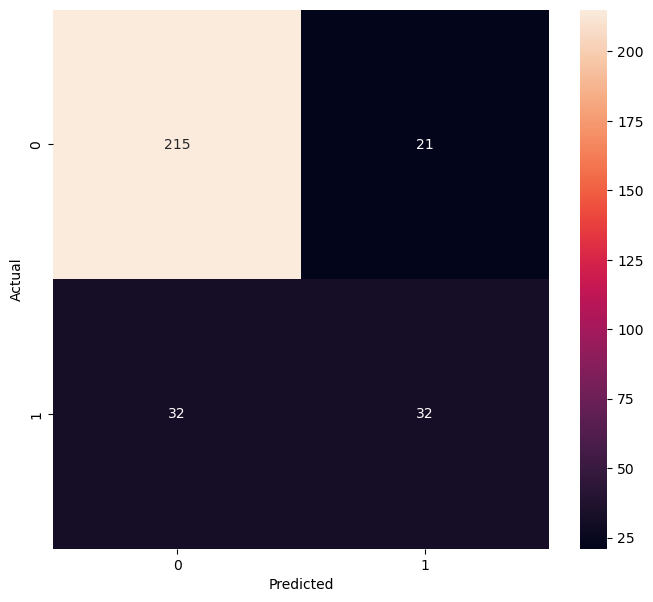

In [ ]:
 # Calling the relevant function
tfidf_LR_accuracy, tfidf_LR_precision, tfidf_LR_recall= optimize_params_fast('TF-IDF','Logistic Regression')

####  Classification - Logistic Regression & BOW 

Fitting 5 folds for each of 72 candidates, totalling 360 fits
The accuracy using BOW as a vectorizer and Logistic Regression as a classifier is: 82.00%
The precision using BOW as a vectorizer and Logistic Regression as a classifier is: 57.58%
The recall using BOW as a vectorize and Logistic Regression as a classifier is: 59.38%
The best parameters for the BOW as a vectorizer and Logistic Regression are: {'classifier__max_iter': 200, 'classifier__solver': 'liblinear', 'vectorizer__encoding': 'latin-1', 'vectorizer__min_df': 0, 'vectorizer__ngram_range': (1, 2)}


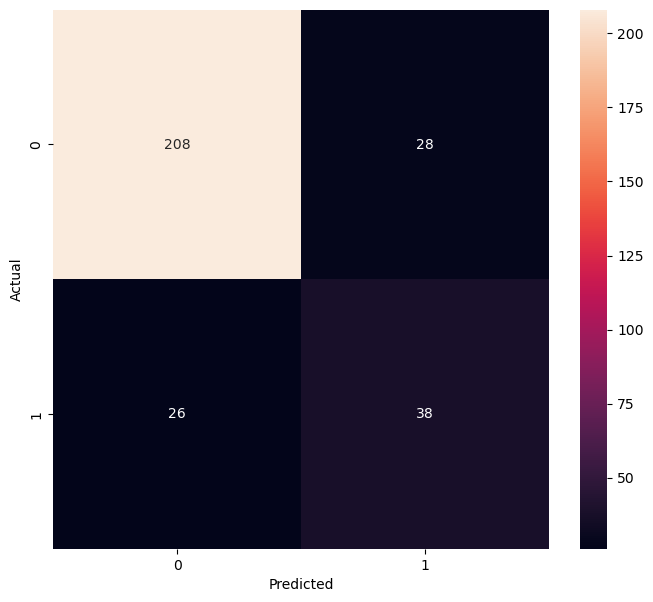

In [ ]:
 # Calling the relevant function
BOW_LR_accuracy,BOW_LR_precision,BOW_LR_recall= optimize_params_fast('BOW','Logistic Regression')

#### Classification - Logistic Regression & Doc2Vec 


Fitting 5 folds for each of 30 candidates, totalling 150 fits
The accuracy using Doc2Vec and Logistic Regression as a classifier is: 80.67%
The precision using Doc2Vec and Logistic Regression as a classifier is: 56.52%
The recall using Doc2Vec and Logistic Regression as a classifier is: 40.62%
The best parameters for the Logistic Regression are: {'clf__C': 0.1, 'clf__max_iter': 200, 'clf__solver': 'liblinear'}


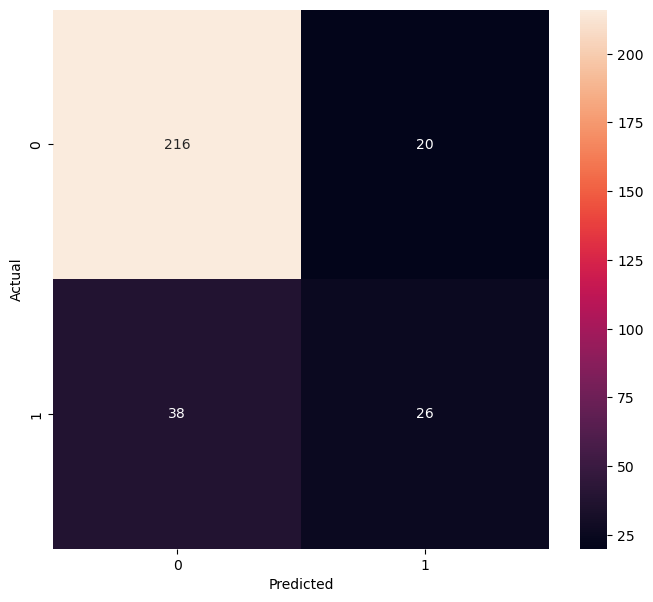

In [ ]:
 # Calling the relevant function
doc2vec_LR_accuracy, doc2vec_LR_precision, doc2vec_LR_recall = train_and_predict('Logistic Regression')

#### Classification - Logistic Regression & Word2Vec


Fitting 5 folds for each of 30 candidates, totalling 150 fits
The accuracy using Word2Vec and Logistic Regression as a classifier is: 79.67%
The precision using Word2Vec and Logistic Regression as a classifier is: 71.43%
The recall using Word2Vec and Logistic Regression as a classifier is: 7.81%
The best parameters for the Logistic Regression are: {'clf__C': 100, 'clf__max_iter': 200, 'clf__solver': 'lbfgs'}


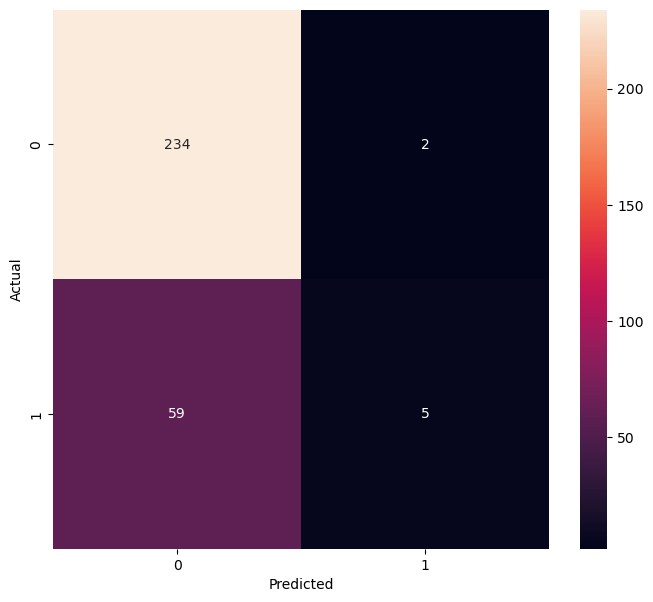

In [ ]:
 # Calling the relevant function
word2vec_LR_accuracy, word2vec_LR_precision, word2vec_LR_recall = run_classifier('Logistic Regression')

####  Classification - Logistic Regression & DistilBERT


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

The accuracy using Bert and Logistic Regression as a classifier is: 87.67%
The precision using Bert and Logistic Regression as a classifier is: 71.43%
The recall using Bert and Logistic Regression as a classifier is: 70.31%
The best parameters for the Logistic Regression are: {'clf__C': 1, 'clf__max_iter': 200, 'clf__solver': 'liblinear'}


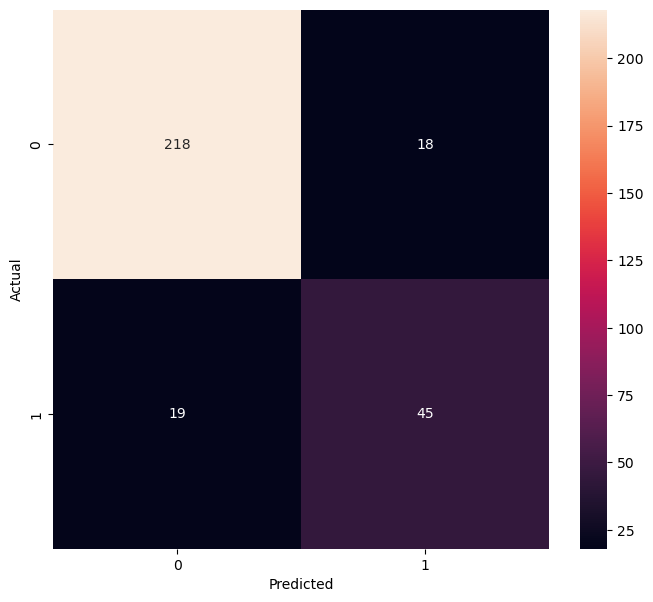

In [ ]:
# Calling the relevant function
bert_LR_accuracy, bert_LR_precision, bert_LR_recall = BERT_opt_params('Logistic Regression')

# KNN as a classifier 

 For the upcoming models, we will use KNN as the classifier. Each of the five vectorizers, namely BOW, TF-IDF, Doc2Vec, Word2Vec, and DistilBERT, will be paired with this classifier individually. The functions previously created in the notebook for each respective vectorizer will now be utilized in combination with the KNN classifier. For every combination, the performance metrics (accuracy, precision, and recall) are recorded and stored. These metrics will be presented in the final table located at the conclusion of this notebook.

#### Classification - KNN & TF-IDF

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

The accuracy using TF-IDF as a vectorizer and KNN as a classifier is: 78.33%
The precision using TF-IDF as a vectorizer and KNN as a classifier is: 49.25%
The recall using TF-IDF as a vectorize and KNN as a classifier is: 51.56%
The best parameters for the TF-IDF as a vectorizer and KNN are: {'classifier__n_neighbors': 2, 'classifier__p': 2, 'classifier__weights': 'uniform', 'vectorizer__encoding': 'latin-1', 'vectorizer__min_df': 0, 'vectorizer__ngram_range': (1, 2), 'vectorizer__norm': 'l2', 'vectorizer__sublinear_tf': 'False'}


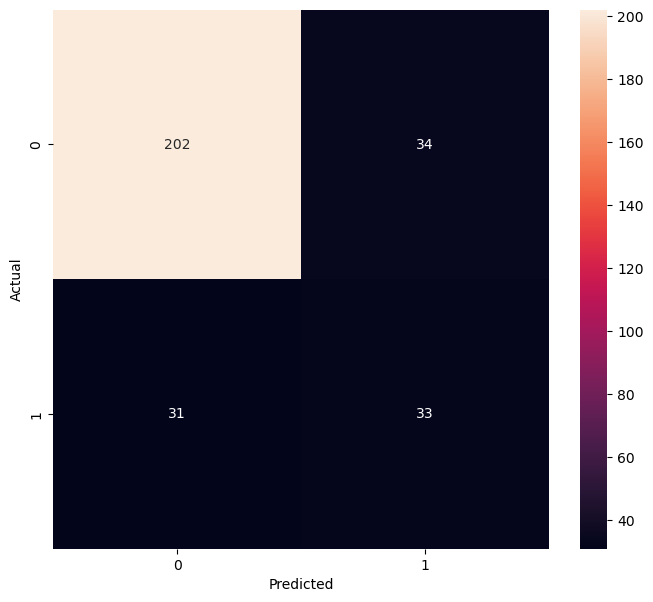

In [ ]:
 # Calling the relevant function
tfidf_knn_accuracy, tfidf_knn_precision, tfidf_knn_recall= optimize_params_fast('TF-IDF','KNN')

#### Classification - KNN & BOW 

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

The accuracy using BOW as a vectorizer and KNN as a classifier is: 81.00%
The precision using BOW as a vectorizer and KNN as a classifier is: 56.14%
The recall using BOW as a vectorize and KNN as a classifier is: 50.00%
The best parameters for the BOW as a vectorizer and KNN are: {'classifier__n_neighbors': 2, 'classifier__p': 1, 'classifier__weights': 'distance', 'vectorizer__encoding': 'latin-1', 'vectorizer__min_df': 0, 'vectorizer__ngram_range': (1, 1)}


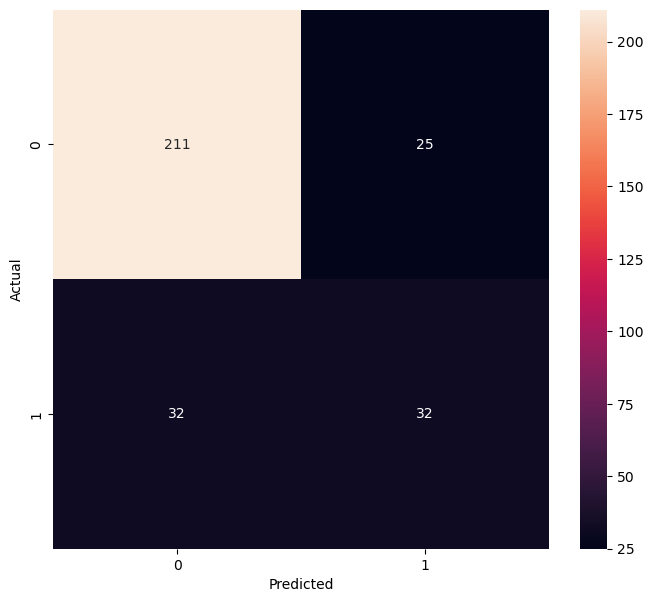

In [ ]:
 # Calling the relevant function
bow_knn_accuracy, bow_knn_precision, bow_knn_recall= optimize_params_fast('BOW','KNN')

#### Classification - KNN & Doc2Vec


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

The accuracy using Doc2Vec and KNN as a classifier is: 83.00%
The precision using Doc2Vec and KNN as a classifier is: 67.57%
The recall using Doc2Vec and KNN as a classifier is: 39.06%
The best parameters for the KNN are: {'clf__n_neighbors': 6, 'clf__p': 2, 'clf__weights': 'distance'}


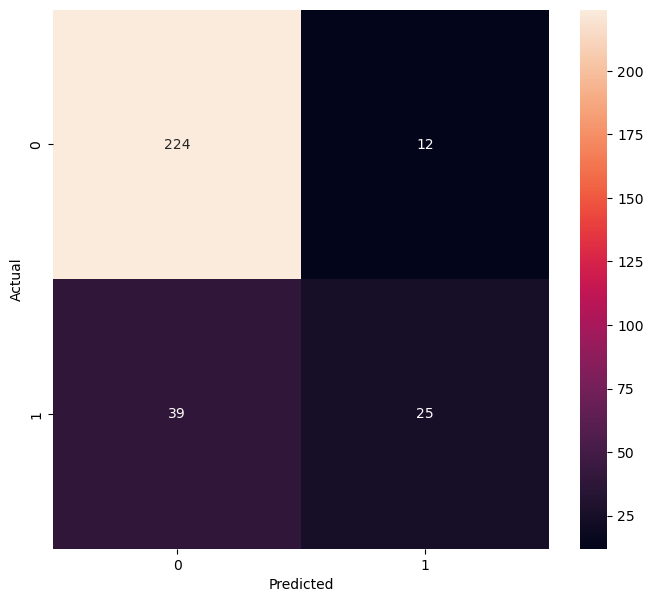

In [ ]:
 # Calling the relevant function
doc2vec_knn_accuracy, doc2vec_knn_precision, doc2vec_knn_recall = train_and_predict('KNN')

However, using Doc2Vec as a vectorizer is expected to result in different accuracies than using BOW or TF-IDF because Doc2Vec creates document embeddings that capture the semantic meaning of the text, which is not the case for BOW or TF-IDF. Therefore, when using Doc2Vec, the KNN model is trained on semantic information rather than just word counts, and this could result in a different accuracy compared to using BOW or TF-IDF.

#### Classification - KNN & Word2Vec


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

The accuracy using Word2Vec and KNN as a classifier is: 75.33%
The precision using Word2Vec and KNN as a classifier is: 37.50%
The recall using Word2Vec and KNN as a classifier is: 23.44%
The best parameters for the KNN are: {'clf__n_neighbors': 4, 'clf__p': 1, 'clf__weights': 'uniform'}


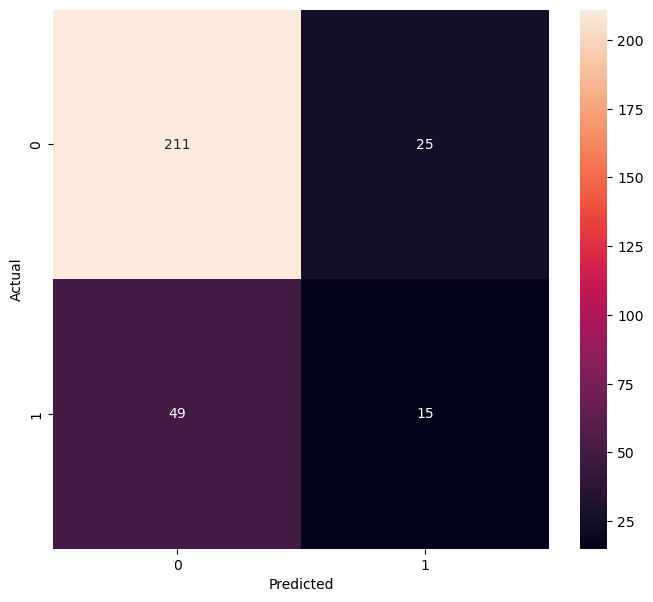

In [ ]:
 # Calling the relevant function
word2vec_knn_accuracy, word2vec_knn_precision, word2vec_knn_recall = run_classifier('KNN')

#### Classification - KNN & DistilBERT 


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/guillaume/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

The accuracy using Bert and KNN as a classifier is: 83.67%
The precision using Bert and KNN as a classifier is: 62.71%
The recall using Bert and KNN as a classifier is: 57.81%
The best parameters for the KNN are: {'clf__n_neighbors': 6, 'clf__p': 1, 'clf__weights': 'uniform'}


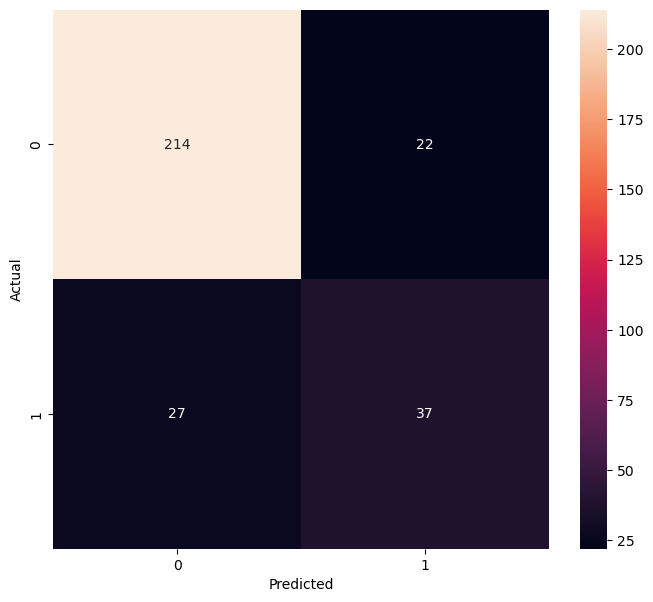

In [ ]:
# Calling the relevant function
bert_knn_accuracy, bert_knn_precision, bert_knn_recall = BERT_opt_params('KNN')

# Decision Tree as a classifier 
 For the upcoming models, we will use Decision Tree as the classifier. Each of the five vectorizers, namely BOW, TF-IDF, Doc2Vec, Word2Vec, and DistilBERT, will be paired with this classifier individually. The functions previously created in the notebook for each respective vectorizer will now be utilized in combination with the Decision Tree classifier. For every combination, the performance metrics (accuracy, precision, and recall) are recorded and stored. These metrics will be presented in the final table located at the conclusion of this notebook.

#### Classification - Decision Tree & TF-IDF

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
The accuracy using TF-IDF as a vectorizer and Decision Tree as a classifier is: 80.67%
The precision using TF-IDF as a vectorizer and Decision Tree as a classifier is: 55.36%
The recall using TF-IDF as a vectorize and Decision Tree as a classifier is: 48.44%
The best parameters for the TF-IDF as a vectorizer and Decision Tree are: {'classifier__criterion': 'entropy', 'classifier__max_depth': 13, 'classifier__splitter': 'best', 'vectorizer__encoding': 'utf-8', 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 1), 'vectorizer__norm': 'l2', 'vectorizer__sublinear_tf': 'False'}


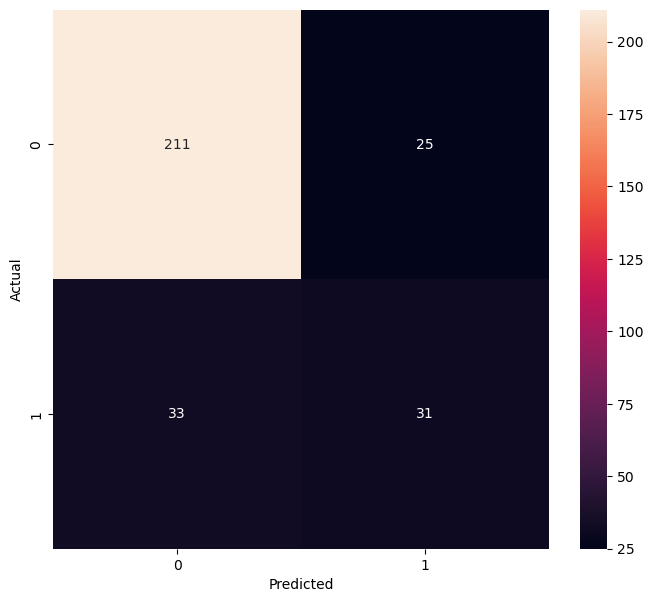

In [ ]:
 # Calling the relevant function
tfidf_tree_accuracy, tfidf_tree_precision, tfidf_tree_recall= optimize_params_fast('TF-IDF','Decision Tree')

#### Classification - Decision Tree & BOW 

Fitting 5 folds for each of 96 candidates, totalling 480 fits
The accuracy using BOW as a vectorizer and Decision Tree as a classifier is: 80.00%
The precision using BOW as a vectorizer and Decision Tree as a classifier is: 53.23%
The recall using BOW as a vectorize and Decision Tree as a classifier is: 51.56%
The best parameters for the BOW as a vectorizer and Decision Tree are: {'classifier__criterion': 'entropy', 'classifier__max_depth': 13, 'classifier__splitter': 'best', 'vectorizer__encoding': 'utf-8', 'vectorizer__min_df': 5, 'vectorizer__ngram_range': (1, 2)}


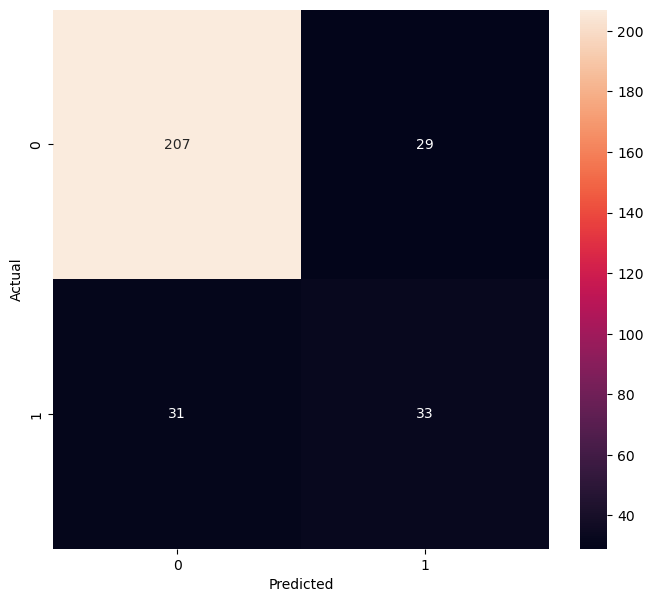

In [ ]:
 # Calling the relevant function
bow_tree_accuracy, bow_tree_precision, bow_tree_recall= optimize_params_fast('BOW','Decision Tree')

#### Classification - Decision Tree & Doc2Vec

Fitting 5 folds for each of 36 candidates, totalling 180 fits
The accuracy using Doc2Vec and Decision Tree as a classifier is: 79.67%
The precision using Doc2Vec and Decision Tree as a classifier is: 52.38%
The recall using Doc2Vec and Decision Tree as a classifier is: 51.56%
The best parameters for the Decision Tree are: {'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__splitter': 'best'}


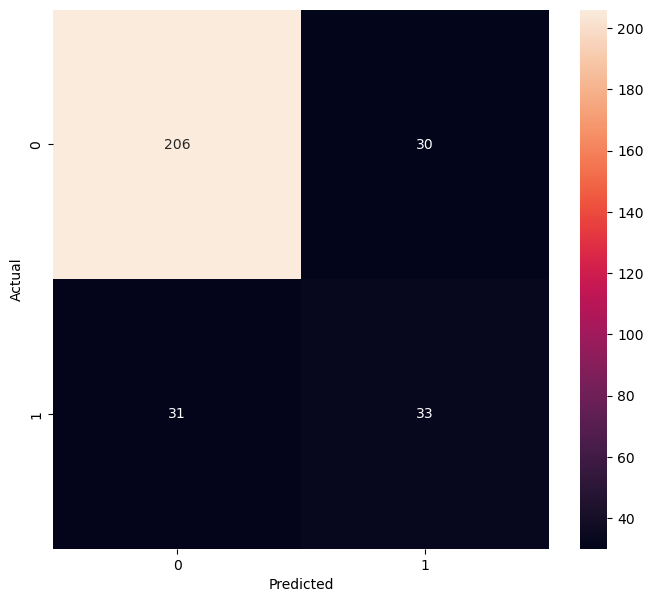

In [ ]:
 # Calling the relevant function
doc2vec_tree_accuracy, doc2vec_tree_precision, doc2vec_tree_recall = train_and_predict('Decision Tree')

####  Classification - Decision Tree & Word2Vec
 used this source: https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381 (cette source est basé sur random forest comme clasfier, la j'essaie d'implémeter avec Dcesion tree)
 

Fitting 5 folds for each of 36 candidates, totalling 180 fits
The accuracy using Word2Vec and Decision Tree as a classifier is: 78.67%
The precision using Word2Vec and Decision Tree as a classifier is: 0.00%
The recall using Word2Vec and Decision Tree as a classifier is: 0.00%
The best parameters for the Decision Tree are: {'clf__criterion': 'entropy', 'clf__max_depth': 1, 'clf__splitter': 'best'}


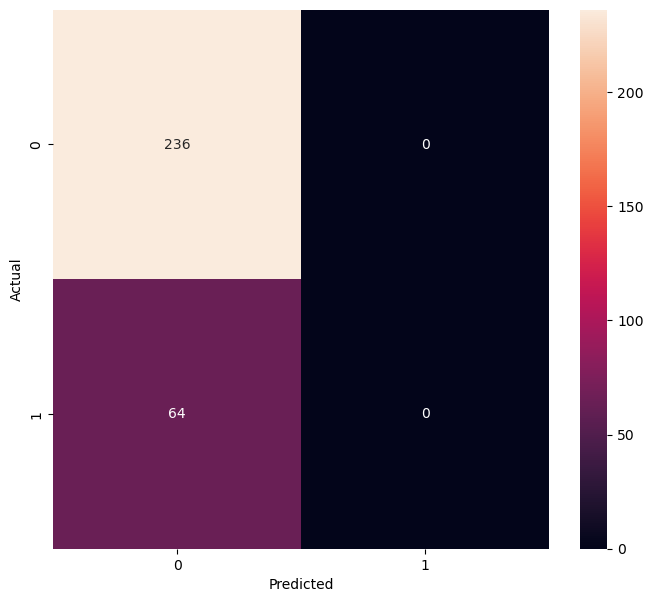

In [ ]:
 # Calling the relevant function
word2vec_tree_accuracy, word2vec_tree_precision, word2vec_tree_recall = run_classifier('Decision Tree')

#### Classification - Decision Tree & DistilBERT

Fitting 5 folds for each of 36 candidates, totalling 180 fits
The accuracy using Bert and Decision Tree as a classifier is: 79.67%
The precision using Bert and Decision Tree as a classifier is: 53.19%
The recall using Bert and Decision Tree as a classifier is: 39.06%
The best parameters for the Decision Tree are: {'clf__criterion': 'entropy', 'clf__max_depth': 4, 'clf__splitter': 'best'}


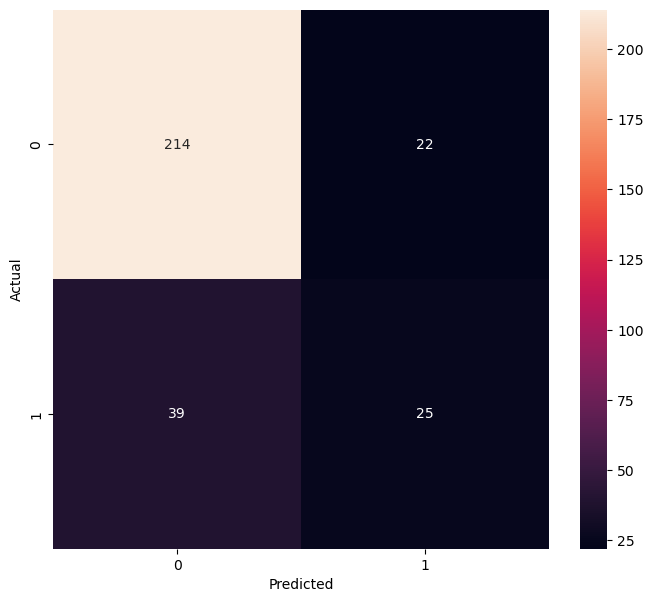

In [ ]:
# Calling the relevant function
bert_tree_accuracy, bert_tree_precision, bert_tree_recall = BERT_opt_params('Decision Tree')

# Radom Forest as a classifier 
For the upcoming models, we will use Random Forest as the classifier. Each of the five vectorizers, namely BOW, TF-IDF, Doc2Vec, Word2Vec, and DistilBERT, will be paired with this classifier individually. The functions previously created in the notebook for each respective vectorizer will now be utilized in combination with the Random Forest classifier. For every combination, the performance metrics (accuracy, precision, and recall) are recorded and stored. These metrics will be presented in the final table located at the conclusion of this notebook.

#### Classification - Random Forest & TF-IDF

Fitting 5 folds for each of 128 candidates, totalling 640 fits
The accuracy using TF-IDF as a vectorizer and Random Forest as a classifier is: 81.67%
The precision using TF-IDF as a vectorizer and Random Forest as a classifier is: 56.92%
The recall using TF-IDF as a vectorize and Random Forest as a classifier is: 57.81%
The best parameters for the TF-IDF as a vectorizer and Random Forest are: {'classifier__criterion': 'entropy', 'classifier__n_estimators': 17, 'vectorizer__encoding': 'utf-8', 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 2), 'vectorizer__norm': 'l2', 'vectorizer__sublinear_tf': 'False'}


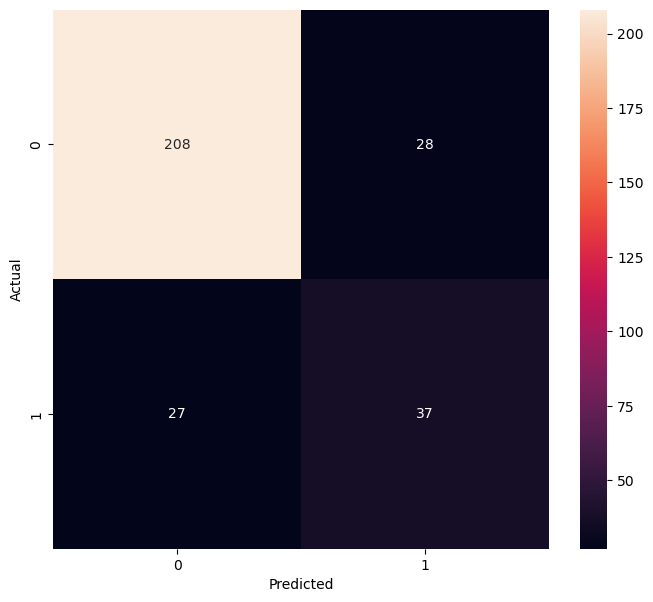

In [ ]:
 # Calling the relevant function
tfidf_rf_accuracy, tfidf_rf_precision, tfidf_rf_recall= optimize_params_fast('TF-IDF','Random Forest')

#### Classification - Random Forest & BOW

Fitting 5 folds for each of 48 candidates, totalling 240 fits
The accuracy using BOW as a vectorizer and Random Forest as a classifier is: 80.33%
The precision using BOW as a vectorizer and Random Forest as a classifier is: 53.62%
The recall using BOW as a vectorize and Random Forest as a classifier is: 57.81%
The best parameters for the BOW as a vectorizer and Random Forest are: {'classifier__criterion': 'entropy', 'classifier__n_estimators': 17, 'vectorizer__encoding': 'latin-1', 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 2)}


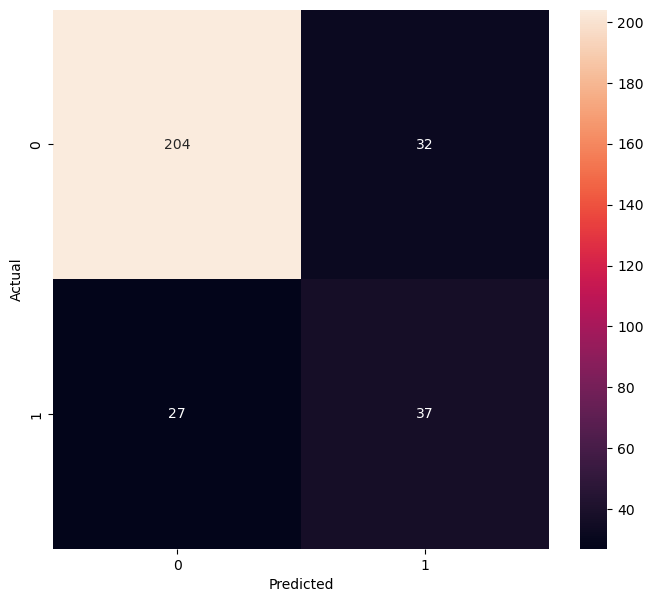

In [ ]:
 # Calling the relevant function
bow_rf_accuracy, bow_rf_precision, bow_rf_recall= optimize_params_fast('BOW','Random Forest')

#### Classification - Random Forest & Doc2Vec

Fitting 5 folds for each of 20 candidates, totalling 100 fits
The accuracy using Doc2Vec and Random Forest as a classifier is: 80.33%
The precision using Doc2Vec and Random Forest as a classifier is: 57.58%
The recall using Doc2Vec and Random Forest as a classifier is: 29.69%
The best parameters for the Random Forest are: {'clf__criterion': 'gini', 'clf__n_estimators': 9}


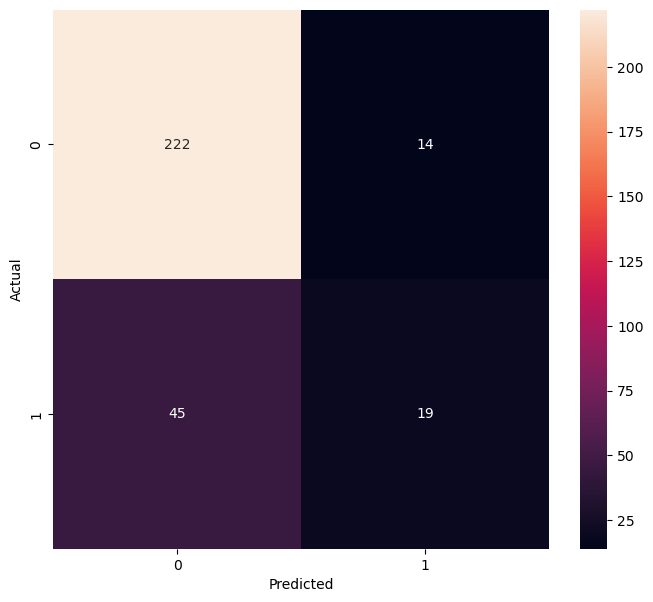

In [ ]:
 # Calling the relevant function
doc2vec_rf_accuracy, doc2vec_rf_precision, doc2vec_rf_recall = train_and_predict('Random Forest')

 #### Classification - Random Forest & Word2Vec

Fitting 5 folds for each of 20 candidates, totalling 100 fits
The accuracy using Word2Vec and Random Forest as a classifier is: 74.00%
The precision using Word2Vec and Random Forest as a classifier is: 25.00%
The recall using Word2Vec and Random Forest as a classifier is: 10.94%
The best parameters for the Random Forest are: {'clf__criterion': 'entropy', 'clf__n_estimators': 9}


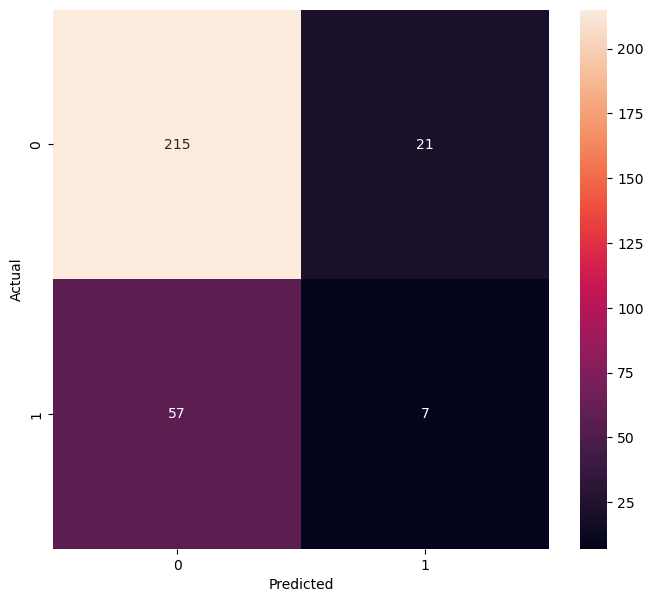

In [ ]:
 # Calling the relevant function
word2vec_rf_accuracy, word2vec_rf_precision, word2vec_rf_recall = run_classifier('Random Forest')

#### Classification - Random Forest & DistilBERT

Fitting 5 folds for each of 20 candidates, totalling 100 fits
The accuracy using Bert and Random Forest as a classifier is: 85.00%
The precision using Bert and Random Forest as a classifier is: 71.11%
The recall using Bert and Random Forest as a classifier is: 50.00%
The best parameters for the Random Forest are: {'clf__criterion': 'entropy', 'clf__n_estimators': 9}


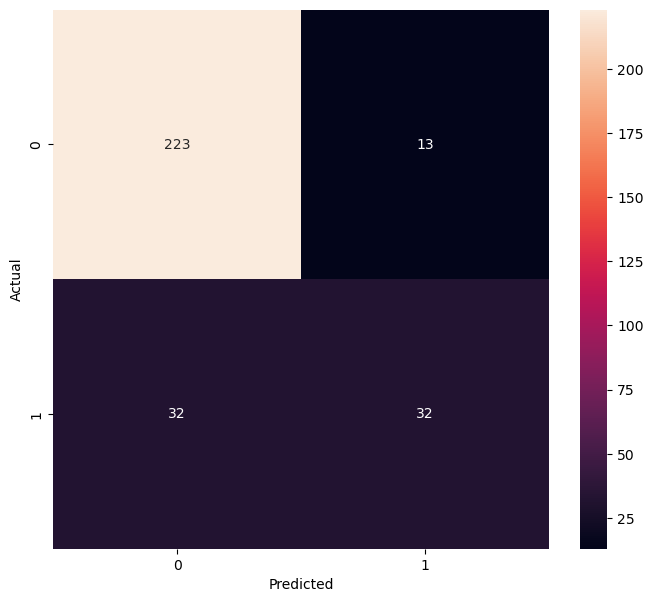

In [ ]:
# Calling the relevant function
bert_rf_accuracy, bert_rf_precision, bert_rf_recall = BERT_opt_params('Random Forest')

# Table - Final Results
Based on the functions developed earlier in this notebook, the performance metrics of the 20 models are presented in the following table. With four classifiers and five vectorizers evaluated across three performance metrics, a total of 60 numerical values represent the evaluation results. This comprehensive table offers an overview of the performance of each individual (i.e., each combination) model.

In [ ]:
# Create the dictionary of model results
model_results = {
    'Logistic Regression': {'accuracy': {'BOW': BOW_LR_accuracy, 'TF-IDF': tfidf_LR_accuracy, 'Doc2Vec': doc2vec_LR_accuracy, 'Word2Vec': word2vec_LR_accuracy, 'Bert': bert_LR_accuracy},
                            'precision': {'BOW': BOW_LR_precision, 'TF-IDF': tfidf_LR_precision, 'Doc2Vec': doc2vec_LR_precision, 'Word2Vec': word2vec_LR_precision, 'Bert': bert_LR_precision},
                            'recall': {'BOW': BOW_LR_recall, 'TF-IDF': tfidf_LR_recall, 'Doc2Vec': doc2vec_LR_recall, 'Word2Vec': word2vec_LR_recall, 'Bert': bert_LR_recall}},
    'KNN': {'accuracy': {'BOW': bow_knn_accuracy, 'TF-IDF': tfidf_knn_accuracy, 'Doc2Vec': doc2vec_knn_accuracy, 'Word2Vec': word2vec_knn_accuracy, 'Bert': bert_knn_accuracy},
            'precision': {'BOW': bow_knn_precision, 'TF-IDF': tfidf_knn_precision, 'Doc2Vec': doc2vec_knn_precision, 'Word2Vec': word2vec_knn_precision, 'Bert': bert_knn_precision},
            'recall': {'BOW': bow_knn_recall, 'TF-IDF': tfidf_knn_recall, 'Doc2Vec': doc2vec_knn_recall, 'Word2Vec': word2vec_knn_recall, 'Bert': bert_knn_recall}},
    'Decision Tree': {'accuracy': {'BOW': bow_tree_accuracy, 'TF-IDF': tfidf_tree_accuracy, 'Doc2Vec': doc2vec_tree_accuracy, 'Word2Vec': word2vec_tree_accuracy, 'Bert': bert_tree_accuracy},
                      'precision': {'BOW': bow_tree_precision, 'TF-IDF': tfidf_tree_precision, 'Doc2Vec': doc2vec_tree_precision, 'Word2Vec': word2vec_tree_precision, 'Bert': bert_tree_precision},
                      'recall': {'BOW': bow_tree_recall, 'TF-IDF': tfidf_tree_recall, 'Doc2Vec': doc2vec_tree_recall, 'Word2Vec': word2vec_tree_recall, 'Bert': bert_tree_recall}},
    'Random Forest': {'accuracy': {'BOW': bow_rf_accuracy, 'TF-IDF': tfidf_rf_accuracy, 'Doc2Vec': doc2vec_rf_accuracy, 'Word2Vec': word2vec_rf_accuracy, 'Bert': bert_rf_accuracy},
                      'precision': {'BOW': bow_rf_precision, 'TF-IDF': tfidf_rf_precision, 'Doc2Vec': doc2vec_rf_precision, 'Word2Vec': word2vec_rf_precision, 'Bert': bert_rf_precision},
                      'recall': {'BOW': bow_rf_recall, 'TF-IDF': tfidf_rf_recall, 'Doc2Vec': doc2vec_rf_recall, 'Word2Vec': word2vec_rf_recall, 'Bert': bert_rf_recall}}
}

# Create an empty data list
data=[]

# Iterate over the model results dictionary
for model_name, metrics_dict in model_results.items():
    # Iterate over the metrics dictionary for each model
    for metric_name, vectorizer_dict in metrics_dict.items():
        # Iterate over the vectorizer dictionary for each metric
        for vectorizer, value in vectorizer_dict.items():
            # Create a dictionary for each row of data
            data_dict = {'Model': model_name, 'Metric': metric_name, 'Vectorizer': vectorizer, 'Value': value}
            
            # Append the row of data to the dataframe
            data.append(data_dict)

#add the data to the dataframe
df = pd.DataFrame(data)

# Set the MultiIndex with 'Metric' and 'Vectorizer' as the levels
df.set_index(['Metric', 'Vectorizer'], inplace=True)

# Transpose the dataframe to have models as columns
df = df.pivot(columns='Model', values='Value')

#Display the final table with all the results
df

Model                 Decision Tree     KNN  Logistic Regression   
Metric    Vectorizer                                               
accuracy  BOW                0.8000  0.8100               0.8200  \
          Bert               0.7967  0.8367               0.8767   
          Doc2Vec            0.7967  0.8300               0.8067   
          TF-IDF             0.8067  0.7833               0.8233   
          Word2Vec           0.7867  0.7533               0.7967   
precision BOW                0.5323  0.5614               0.5758   
          Bert               0.5319  0.6271               0.7143   
          Doc2Vec            0.5238  0.6757               0.5652   
          TF-IDF             0.5536  0.4925               0.6038   
          Word2Vec           0.0000  0.3750               0.7143   
recall    BOW                0.5156  0.5000               0.5938   
          Bert               0.3906  0.5781               0.7031   
          Doc2Vec            0.5156  0.3906               0.4062   
          TF-IDF             0.4844  0.5156               0.5000   
          Word2Vec           0.0000  0.2344               0.0781   

Model                 Random Forest  
Metric    Vectorizer                 
accuracy  BOW                0.8033  
          Bert               0.8500  
          Doc2Vec            0.8033  
          TF-IDF             0.8167  
          Word2Vec           0.7400  
precision BOW                0.5362  
          Bert               0.7111  
          Doc2Vec            0.5758  
          TF-IDF             0.5692  
          Word2Vec           0.2500  
recall    BOW                0.5781  
          Bert               0.5000  
          Doc2Vec            0.2969  
          TF-IDF             0.5781  
          Word2Vec           0.1094

For the analysis this table, we kindly refer the reader of this notebook to the accompanying README file, which can be found on the GitHub repository.